In [19]:
# Filename       : TrussXYStructure.py
# Description    : Finite Element Analysis using Truss Elements
# Author         : Rohan Dixit
# Address line 1 : Department of Civil Engineering, IIT, Kharagpur
# Address line 2 :MW-205, Meghnad Saha Hall, IIT, Kharagpur
# Purpose        : Analysis of Trusses in Two Dimensions
# Created        : 01/08/2018
# Last modified  : 06/09/2018

In [20]:
import math
import numpy as np

In [21]:
class Node(object):
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value

In [22]:
class Element(object):
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value

In [23]:
class ElementTrussXY(Element):
    def __init__(self,**kwargs):
        Element.__init__(self,**kwargs)
                
        self.mdof=4        
        self.ke=np.zeros((4,4),float)
        self.ok=np.zeros((4,4),float)
        self.ot=np.zeros((4,4),float)
        self.jdofv=np.zeros((4),int)

                         
    def computeStiffnessMatrix(self,NODE):
        
        self.c=np.zeros((self.mdof,self.mdof),float)
        
        for i in range(self.mdof):
            for j in range(self.mdof):
                self.c[i,j]=0.0

        n1=self.nodes[0]
        n2=self.nodes[1]
        self.jdofv[0]=2*n1-1
        self.jdofv[1]=2*n1
        self.jdofv[2]=2*n2-1
        self.jdofv[3]=2*n2
                         
        xx=NODE[n2].x-NODE[n1].x
        yy=NODE[n2].y-NODE[n1].y

        A=self.A
 
        E=self.E

        L=math.sqrt((xx*xx+yy*yy))
        for i in range(4):
            for j in range(4):
                self.ok[i,j]=0.0
                self.ot[i,j]=0.0
            self.ot[i,i]=1.0    

        C = xx / L
        S = yy / L
        self.ot[0,0]=C
        self.ot[0,1]=S
        self.ot[1,0]=-S
        self.ot[1,1]=C
        self.ot[2,2]=C
        self.ot[2,3]=S
        self.ot[3,2]=-S
        self.ot[3,3]=C

        AE_by_L = A * E / L

        self.ke[0,0]=      AE_by_L
        self.ke[0,2]=     -AE_by_L
    
        self.ke[2,0]=     -AE_by_L
        self.ke[2,2]=      AE_by_L

        for i in range(4):
            for j in range(4):
                self.c[i,j]=0.0
                for k in range(4):
                    self.c[i,j]=self.c[i,j]+self.ot[k,i]*self.ke[k,j]

        for i in range(4):
            for j in range(4):
                self.ok[i,j]=0.0
                for k in range(4):
                    self.ok[i,j]=self.ok[i,j]+self.c[i,k]*self.ot[k,j]

        del self.c

    def assembleStiffness(self,gk):
        
        for i in range(self.mdof):
            ii=self.jdofv[i]
            if ii > 0:
                for j in range(self.mdof):
                    jj=self.jdofv[j]
                    if jj > 0:
                       gk[ii-1,jj-1]=gk[ii-1,jj-1]+self.ok[i,j]
                        
    def computeMemberForces(self,NODE):
            self.computeStiffnessMatrix(NODE)
            mfg=[0,0,0,0]
            mfl=[0,0,0,0]
            disp=[0,0,0,0]
            n1=self.nodes[0]
            n2=self.nodes[1]
            N1=NODE[n1]
            N2=NODE[n2]
            disp[0]=N1.Dx
            disp[1]=N1.Dy
            disp[2]=N2.Dx
            disp[3]=N2.Dy
           
            for i in range(4):
                mfg[i]=0.0
                for j in range(4):
                    mfg[i]=mfg[i]+self.ok[i,j]*disp[j]
                    
            for i in range(4):
                mfl[i]=0.0
                for j in range(4):
                    mfl[i]=mfl[i]+self.ot[i,j]*mfg[j]

            self.mfl=mfl

In [24]:
class Structure(object):
   
    def __init__(self,**kwargs):
        self.title='Untitled'
        self.numnode=0
        self.numelem=0
        self.NODE=dict()
        self.ELEM=dict()
        self.NODE_LIST=list()
        self.ELEM_LIST=list()

    def node(self, **kwargs):
        if 'NODE' not in vars(self):
            self.NODE=dict()
        if 'NODE_LIST' not in vars(self):
            self.NODE_LIST=list()
        
        if 'nid' in kwargs:
            nid=kwargs['nid']
            self.NODE[nid]=Node(**kwargs)
            self.NODE_LIST.append(nid)
            self.numnode=self.numnode+1
                

    def element(self, **kwargs):
        if 'ELEM' not in vars(self):
            self.ELEM=dict()
        if 'ELEM_LIST' not in vars(self):
            self.ELEM_LIST=list()

        if 'eid' in kwargs:
            eid=kwargs['eid']
            if 'etype' in kwargs:
                self.etype=kwargs['etype']
            if self.etype == 'TrussXY':
               self.ELEM[eid]=ElementTrussXY(**kwargs)
            self.ELEM_LIST.append(eid)
            self.numelem=self.numelem+1
            
    def solve(self,**kwargs):
        self.ndof=2*self.numnode
        self.gk=np.zeros((self.ndof,self.ndof),float)
        self.gp=np.zeros((self.ndof,1),float)

        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeStiffnessMatrix(self.NODE)
            self.ELEM[eid].assembleStiffness(self.gk)

        for nid in self.NODE_LIST:
            N=self.NODE[nid]
            i1=2*nid-1
            i2=2*nid
            
            if 'Fx' in vars(N):
                self.gp[i1-1,0]=N.Fx

            if 'Fy' in vars(N):
                self.gp[i2-1,0]=N.Fy

            if 'idx' in vars(N):
                idx=N.idx
                if idx == 1:
                    for i in range(self.ndof):
                        self.gk[i,i1-1]=0.0
                        self.gk[i1-1,i]=0.0
                    self.gk[i1-1,i1-1]=1.0

            if 'idy' in vars(N):
                idy=N.idy
                if idy == 1:
                    for i in range(self.ndof):
                        self.gk[i,i2-1]=0.0
                        self.gk[i2-1,i]=0.0
                    self.gk[i2-1,i2-1]=1.0

        self.disp=np.linalg.solve(self.gk,self.gp)

        for nid in self.NODE_LIST:
            i1=2*nid-1
            i2=2*nid
            self.NODE[nid].Dx=self.disp[i1-1,0]
            self.NODE[nid].Dy=self.disp[i2-1,0]

        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeMemberForces(self.NODE)
            
    def showStructure(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value
        plt.axis((-5.0,55.0,-5.0,55.0))
        ax=plt.gca()
        plt.axis('off')
        for eid in self.ELEM_LIST:
            n1=self.ELEM[eid].nodes[0]
            n2=self.ELEM[eid].nodes[1]
            N1=self.NODE[n1]
            N2=self.NODE[n2]
            p1=[N1.x,N1.y]
            p2=[N2.x,N2.y]
#            print(eid,n1,n2,p1,p2)
            l=mlines.Line2D([N1.x,N2.x],[N1.y,N2.y])
            ax.add_line(l)
            
        plt.show()
            

In [25]:
def example_101a_truss_bridge_xy():
        a=5.5
        h=7.0
        L=6*a
        A_bot=0.1
        A_top=0.1
        A_diag=0.1
        A_vert=0.1
        Iz_bot=0.5e-05
        Iz_top=0.5e-05
        Iz_diag=0.5e-05
        Iz_vert=0.5e-05
        E=2.0e10
        rho=7850
        m_bar=rho*A_bot
        pstr=Structure(etype='TrussXY',title="Truss Bridge - span 33 m")
        
        pstr.node(nid=1,tagid='L0',x=0.0,  y=0, idx=1, idy=1 )
        pstr.node(nid=2,tagid='L1',x=a, y=0, Fy=-300000.0 )
        pstr.node(nid=3,tagid='L2',x=2*a, y=0, Fy=-300000.0 )
        pstr.node(nid=4,tagid='L3',x=3*a, y=0, Fy=-300000.0 )
        pstr.node(nid=5,tagid='L4',x=4*a, y=0, Fy=-300000.0 )
        pstr.node(nid=6,tagid='L5',x=5*a, y=0, Fy=-300000.0 )
        pstr.node(nid=7,tagid='L6',x=6*a, y=0, idy=1)
        
        pstr.node(nid=8,tagid='U1',x=a, y=h )
        pstr.node(nid=9,tagid='U2',x=2*a, y=h )
        pstr.node(nid=10,tagid='U3',x=3*a, y=h )
        pstr.node(nid=11,tagid='U4',x=4*a, y=h )
        pstr.node(nid=12,tagid='U5',x=5*a, y=h )
         

        pstr.element(eid=1,  tagid='L0-L1',etype='TrussXY',nodes=(1,2),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=2,  tagid='L1-L2',nodes=(2,3),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=3,  tagid='L2-L3',nodes=(3,4),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=4,  tagid='L3-L4',nodes=(4,5),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=5,  tagid='L4-L5',nodes=(5,6),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=6,  tagid='L5-L6',nodes=(6,7),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        
        pstr.element(eid=7,  tagid='U1-U2',nodes=(8,9),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=8, tagid='U2-U3',nodes=(9,10),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=9, tagid='U3-U4',nodes=(10,11),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=10, tagid='U4-U5',nodes=(11,12),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
         
        
        pstr.element(eid=11, tagid='L0-U1',nodes=(1,8),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=12, tagid='L1-U2',nodes=(2,9),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=13, tagid='L2-U3',nodes=(3,10),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=14, tagid='L4-U3',nodes=(5,10),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=15, tagid='L5-U4',nodes=(6,11),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=16, tagid='L6-U5',nodes=(7,12),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
         
        
        pstr.element(eid=17, tagid='L1-U1',nodes=(2,8),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=18, tagid='L2-U2',nodes=(3,9),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=19, tagid='L3-U3',nodes=(4,10),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=20, tagid='L4-U4',nodes=(5,11),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=21, tagid='L5-U5',nodes=(6,12),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
         
         
        
        return pstr

#        pstr.solve()
        
#        print('Nodes')
#        for nid in pstr.NODE_LIST:
#            N=pstr.NODE[nid]
#            print(nid,N.x,N.y,N.Dx,N.Dy)
            
#        print('Elements')

#        for eid in pstr.ELEM_LIST:
#            E=pstr.ELEM[eid]
#            print(eid,E.nodes,E.A,E.E,E.mfl[0])


In [26]:
# Prepare model

pstr=example_101a_truss_bridge_xy()

pstr.solve()

print ('Nodes')

for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print (vars(N))

print('Nodes')
for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print(N.nid,N.x,N.y)
    
print('Elements')

for eid in pstr.ELEM_LIST:
    E=pstr.ELEM[eid]
    print(E.eid,E.nodes,E.A,E.E,E.mfl[0])
    



Nodes
{'nid': 1, 'tagid': 'L0', 'x': 0.0, 'y': 0, 'idx': 1, 'idy': 1, 'Dx': 0.0, 'Dy': 0.0}
{'nid': 2, 'tagid': 'L1', 'x': 5.5, 'y': 0, 'Fy': -300000.0, 'Dx': 0.0016205357142857154, 'Dy': -0.016937204597525898}
{'nid': 3, 'tagid': 'L2', 'x': 11.0, 'y': 0, 'Fy': -300000.0, 'Dx': 0.0042133928571428548, 'Dy': -0.028118149805021028}
{'nid': 4, 'tagid': 'L3', 'x': 16.5, 'y': 0, 'Fy': -300000.0, 'Dx': 0.0071303571428571345, 'Dy': -0.032539901949016008}
{'nid': 5, 'tagid': 'L4', 'x': 22.0, 'y': 0, 'Fy': -300000.0, 'Dx': 0.010047321428571412, 'Dy': -0.028118149805021017}
{'nid': 6, 'tagid': 'L5', 'x': 27.5, 'y': 0, 'Fy': -300000.0, 'Dx': 0.012640178571428544, 'Dy': -0.016937204597525887}
{'nid': 7, 'tagid': 'L6', 'x': 33.0, 'y': 0, 'idy': 1, 'Dx': 0.014260714285714253, 'Dy': 0.0}
{'nid': 8, 'tagid': 'U1', 'x': 5.5, 'y': 7.0, 'Dx': 0.011343749999999972, 'Dy': -0.014312204597525907}
{'nid': 9, 'tagid': 'U2', 'x': 11.0, 'y': 7.0, 'Dx': 0.0097232142857142639, 'Dy': -0.026543149805021028}
{'nid': 1

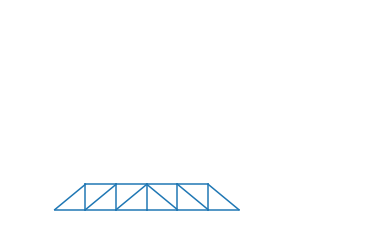

In [27]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

pstr.showStructure()